# Chatbot de Leyes de Tránsito con RAG, GPT-4o y LangChain

## Introducción

En la actualidad, los modelos de lenguaje como GPT-4 han demostrado una gran capacidad para responder preguntas y asistir en la toma de decisiones en múltiples dominios. Sin embargo, estos modelos presentan una limitación fundamental: su conocimiento está restringido a los datos con los que fueron entrenados, lo que puede llevar a respuestas imprecisas o desactualizadas cuando se requiere información específica y en constante actualización, como la contenida en normativas legales.

Uno de los ámbitos donde este problema se hace evidente es en la consulta de regulaciones de tránsito. En Colombia, el Código Nacional de Tránsito regula el comportamiento de conductores, peatones y autoridades viales, estableciendo normativas esenciales para la seguridad y el orden en las vías. Sin embargo, el acceso a esta información no siempre es intuitivo para el ciudadano común, y buscar artículos específicos dentro del documento puede ser un proceso tedioso.

Este proyecto busca solucionar este problema mediante la implementación de un chatbot basado en la técnica de Retrieval-Augmented Generation (RAG). A través del uso de LangChain y LangGraph, se ha desarrollado un sistema capaz de responder preguntas sobre el Código de Tránsito de Colombia, utilizando fragmentos del texto oficial como contexto para generar respuestas precisas y fundamentadas.

El objetivo principal de este trabajo es explorar cómo la integración de modelos de lenguaje con bases de datos de normativa legal puede mejorar el acceso a la información y facilitar la comprensión de regulaciones específicas. Además, se analizará la efectividad del enfoque RAG a lo largo de diferentes escenarios en los que un usuario podría necesitar consultoría legal.

## Metodología

Para abordar el problema de acceso a la normativa del Código de Tránsito de Colombia, se implementó un chatbot basado en la técnica de Retrieval-Augmented Generation (RAG). Esta técnica permite que un modelo de lenguaje consulte una base de datos específica para complementar su conocimiento y generar respuestas más precisas.

La solución se desarrolló utilizando LangChain y LangGraph, herramientas que facilitan la integración de modelos de lenguaje con flujos estructurados de información. A continuación, se describen los principales componentes del sistema.

### Construcción de la base de conocimiento:

El primer paso fue la recopilación del Código de Tránsito de Colombia en formato texto plano (.txt). Para esto es necesario descargar el PDF del Código y convertirlo a dicho formato, y después procesarlo para que quede de esta forma:

In [1]:
from src.process_text import merge_lines

file_path = "ley-769-de-2002-codigo-nacional-de-transito_3704_0.txt"

with open(file_path, 'r') as file:
    lines = file.readlines()


final_text = ''.join(merge_lines(lines))
print(final_text[:1000] + "...")

with open(
    "ley-769-de-2002-codigo-nacional-de-transito_3704_0_processed.txt", 'w'
) as file:
    file.write(final_text)

LEY 769 DE 2002
(Agosto 6)
"Por la cual se expide el Código Nacional de Tránsito Terrestre y se dictan otras disposiciones".
PODER PÚBLICO - RAMA LEGISLATIVA
Ver la Exposición de Motivos, Ley 769 de 2002
TITULOI
DISPOSICIONES GENERALES
CAPITULO I
Principios
ARTÍCULO 1°. ÁMBITO DE APLICACIÓN Y PRINCIPIOS. Las normas del presente Código rigen en todo el territorio nacional y regulan la circulación de los peatones, usuarios, pasajeros, conductores, motociclistas, ciclistas, agentes de tránsito, y vehículos por las vías públicas o privadas que están abiertas al público, o en las vías privadas, que internamente circulen vehículos; así como la actuación y procedimientos de las autoridades de tránsito.
En desarrollo de lo dispuesto por el artículo 24 de la Constitución Política, todo colombiano tiene derecho a circular libremente por el territorio nacional, pero está sujeto a la intervención y reglamentación de las autoridades para garantía de la seguridad y comodidad de los habitantes, espec

### Indexación

Teniendo la base de datos, el primer paso de RAG es tomar dicho texto y dividirlo en fragmentos con el objetivo de indexarlos. Estos fragmentos son los que se consultarán cuando el usuario realice una pregunta, para encontrar aquellos más directamente relacionados a dicha pregunta.

Para realizar esto primero es necesario importar los módulos de LangChain y activar su API (para lo cual fue necesario crear antes una cuenta en la página web de LangSmith) y traer las variables de entorno:

In [2]:
import os
from dotenv import load_dotenv

dotenv_path = '.env'

load_dotenv(dotenv_path)

langsmith_api_key = os.getenv('LANGSMITH_API_KEY')

Para realizar esto primero dividimos el archivo de texto en pequeños elementos de máximo tamaño 300 caracteres, con posibilidad de solapamiento de 50 caracteres. Y a cada fragmento le asociamos un artículo, que es el artículo del cual hace parte dicho fragmento dentro del Código.

In [3]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings


from src.index_formatted_text import clean_section_text, extract_article_sections

# Cargar archivo de texto local
file_path = "ley-769-de-2002-codigo-nacional-de-transito_3704_0_processed.txt"
loader = TextLoader(file_path)
docs = loader.load()

# Procesar el texto original para obtener las secciones de artículos
original_text = docs[0].page_content
article_sections = extract_article_sections(original_text)

# Divisor de texto modificado
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300,
    chunk_overlap=50
)

# Crear splits con la metadata de los artículos
splits = []
for section_text, article_num in article_sections:
    section_splits = text_splitter.create_documents(
        texts=[section_text],
        metadatas=[{
            "source": file_path,
            "source_article": article_num
        }]
    )
    splits.extend(section_splits)

# Indexar con metadata mejorada
vector_store = Chroma.from_documents(
    documents=splits,
    embedding=OpenAIEmbeddings()
)

Cada uno de los fragmentos se ve de la siguiente forma, donde se pueden ver los artículos correspondientes a los fragmentos dentro de `metadata`, donde dice `source_article`.

In [4]:
splits[:10]

[Document(metadata={'source': 'ley-769-de-2002-codigo-nacional-de-transito_3704_0_processed.txt', 'source_article': '1'}, page_content='ÁMBITO DE APLICACIÓN Y PRINCIPIOS. Las normas del presente Código rigen en todo el territorio nacional y regulan la circulación de los peatones, usuarios, pasajeros, conductores, motociclistas, ciclistas, agentes de tránsito, y vehículos por las vías públicas o privadas que están abiertas al público, o en las vías privadas, que internamente circulen vehículos; así como la actuación y procedimientos de las autoridades de tránsito.'),
 Document(metadata={'source': 'ley-769-de-2002-codigo-nacional-de-transito_3704_0_processed.txt', 'source_article': '1'}, page_content='En desarrollo de lo dispuesto por el artículo 24 de la Constitución Política, todo colombiano tiene derecho a circular libremente por el territorio nacional, pero está sujeto a la intervención y reglamentación de las autoridades para garantía de la seguridad y comodidad de los habitantes, e

In [5]:
len(splits)

333

En total resultan 333 fragmentos.

### Extracción

Teniendo los fragmentos indexados, el siguiente paso es añadir la capacidad de extracción dentro de dichos fragmentos. La técnica para realizar esto se llama multi-query, y consiste en lo siguiente.

Primero el usuario realiza una pregunta al sistema, por ejemplo esta:

In [6]:
question = "una moto puede ir por la linea punteada amarilla entre carros?"

La técnica de multi-query se encarga de covertir esta pregunta en cinco preguntas similares, con el objetivo de buscar dentro de los fragmentos indexados aquellos que se parezcan más a aquellas cincco preguntas. Esto permite la extracción de un mayor número de fragmentos, comparado con tan solo buscar respecto a una pregunta. Para esta conversión, de una a cinco preguntas, se usa GPT-3.5, y se escribe un prompt específicamente diseñado con este propósito. En este punto es necesario tener una cuenta de OpenAI, una API key, y créditos cargados dentro de esa cuenta. De lo contrario el siguiente código no correrá:

In [7]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

openai_api_key = os.getenv('OPENAI_API_KEY')

retriever_llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)

template = (
    "Eres una IA asistente modelo de lenguaje. Tu tarea es generar cinco "
    "diferentes versiones de la pregunta dada por el usuario para extraer los "
    "documentos relevantes de una base de datos de vectores. Al generar múltiples "
    "perspectivas de la pregunta del usuario, tu objetivo es ayudar al usuario "
    "a superar algunas de las limitaciones de la búsqueda de similaridad basada "
    "en distancia. Escribe estas preguntas alternativas separadas por caracteres "
    "de nueva línea, sin enumerar ni listar. Pregunta original: {pregunta}"
)

Al pasar este prompt con la pregunta inicial por el modelo de GPT3.5, lo siguiente es el resultado:

In [8]:
prompt_perspectives = ChatPromptTemplate.from_template(template)

generate_queries = (
    prompt_perspectives
    | retriever_llm
    | StrOutputParser()
    | (lambda x: x.split("\n"))
)

generate_queries.invoke(question)

['¿Es posible que una motocicleta circule por la línea punteada amarilla entre los vehículos?',
 '¿Está permitido que una moto se desplace por la línea punteada amarilla entre los automóviles?',
 '¿Puede una motocicleta transitar por la línea punteada amarilla entre los coches?',
 '¿Está autorizado el paso de una moto por la línea punteada amarilla entre los vehículos?',
 '¿Se permite que una motocicleta circule por la línea punteada amarilla entre los carros?']

Esas son las cinco preguntas similares a la pregunta inicial. El siguiente paso es tomar estas preguntas y buscar los fragmentos más parecidos a ellas en la base de datos indexada. Esto se hace realizando búsquedas por similaridad, tomando las representaciones vectoriales de los fragmentos y de las preguntas, y trayendo aquellos fragmentos con menor producto interno con cualquiera de las preguntas. El resultado es el siguiente:

In [9]:
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode

from src.format_fragments import get_unique_union, format_context_with_articles

@tool(response_format="content_and_artifact")
def extraer(pregunta: str):
    """Extrae información relacionada a la pregunta"""

    retrieval_chain = generate_queries | retriever.map() | get_unique_union
    docs = retrieval_chain.invoke({"pregunta": pregunta})

    serialized = format_context_with_articles(docs)

    print("Number of extracted articles: ", len(docs))

    return serialized, docs

retriever = vector_store.as_retriever()

# Empaqueta el retriever en un ToolNode
tools = ToolNode([extraer])
retriever_llm_with_tools = retriever_llm.bind_tools([extraer])

serialized = extraer(question)

print(serialized[:3000] + "...")

C:\Users\Camilo\AppData\Local\Temp\ipykernel_13668\612399951.py:27: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  serialized = extraer(question)


Number of extracted articles:  8
[Artículo 94] No deben transitar sobre las aceras, lugares destinados al tránsito de peatones y por aquellas vías en donde las autoridades competentes lo prohíban. Deben conducir en las vías públicas permitidas o, donde existan, en aquellas especialmente diseñadas para ello.
Deben respetar las señales, normas de tránsito y límites de velocidad.
No deben adelantar a otros vehículos por la derecha o entre vehículos que transiten por sus respectivos carriles. Siempre utilizarán el carril libre a la izquierda del vehículo a sobrepasar.
Deben usar las señales manuales detalladas en el artículo 69 de este código.
Reglamentado por la Resolución del Min. Transporte 1737 de 2004. Los conductores y los acompañantes cuando hubieren, deberán utilizar casco de seguridad, de acuerdo como fije el Ministerio de Transporte.

[Artículo 118] Amarilla: Indica atención para un cambio de luces o señales y para que el cruce sea desalojado por los vehículos que se encuentran e

c:\Users\Camilo\Documents\Estudio\StatsLearning\RAGTransito\src\format_fragments.py:17: LangChainBetaWarning: The function `loads` is in beta. It is actively being worked on, so the API may change.
  doc = loads(doc_str)


En total se extrayeron 7 artículos (de los cuales solo imprimí 5) que eran similares a las 5 preguntas en las que se convirtió a la pregunta original. Como se puede ver, a esta función extraer se le añadió un decorador `@tool`, que servirá más adelante cuando se implemente el chat con LangGraph.

El último paso de RAG, después de la extracción, es la generación. Es decir, la parte que finalmente genera una respuesta basado en el contexto de los fragmentos que ha recibido. Esto se hace llamando a la API de OpenAI nuevamente, pero esta vez a GPT-4o en vez de 3.5. En el mensaje de prompt mostrado a continuacíón, se le describe la tarea de responder, y al final se le adicionan los artículos extraídos que debe usar de contexto. Se ve de esta forma:

In [10]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage

generator_llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

def generate(state: MessagesState):
    """Generate answer."""
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    docs_content = "\n\n".join(doc.content for doc in tool_messages)

    system_message_content = (
        "Eres un asistente de leyes de tránsito en Colombia. Usa las siguientes "
        "piezas de contexto extraídas para responder la pregunta. Si la respuesta "
        "no está en el contexto, di que no sabes. Da algo de detalles, mencionando "
        "el artículo en que te basaste en cada parte de la respuesta al principio "
        "de dicha parte, diciendo \"Basado en el artículo X,...\""
        "\n\n"
        "Contexto con artículos:\n\n"
        f"{docs_content}"
    )

    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    response = generator_llm.invoke(prompt)
    return {"messages": [response]}

Esta función no la ejecutamos todavía porque ya tiene elementos propios de LangGraph. Pero cuando se ejecuta, ya esta es la función que genera la respuesta que se le manda al usuario. Pero antes de ejecutar, se explicará ahora la implementación de LangGraph, y de dónde sale su necesaidad.

### LangGraph

Hasta ahora lo que hemos creado es un robot capaz de responder un mensaje. Sin embargo, una habilidad importante de los chatbots es que son capaces de conocer el historial de mensajes de una misma conversación. Esto se puede lograr con LangGraph, que es una tecnología derivada de LangChain diseñada para tratar los chatbots como grafos, en donde los nodos del grafo se pasan entre el historial de mensajes y otra información de la conversación en forma de un estado. Cada chatbot se puede observar con un grafo equivalente, en donde los nodos del grafo representan la serie de pasos que sigue el chatbot cada vez que recibe un mensaje nuevo.

Para poder visualizarlo, primero procedemos a construir el grafo de este chatbot:



In [11]:
from langgraph.prebuilt import tools_condition
from langgraph.graph import StateGraph, END

def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    response = retriever_llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

graph_builder = StateGraph(MessagesState)

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

Y ahora imprimimos el grafo:

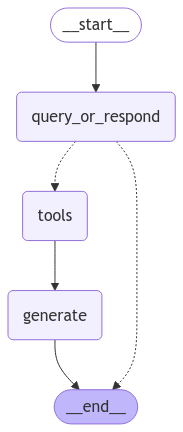

In [12]:
graph

La forma de interpretarlo, es que cada vez que se recibe un mensaje nuevo del usuario, el chatbot comienza a ejecutar las instrucciones desde arriba. Primero manda el mensaje a la función `query_or_respond`, que se encarga de decidir si el mensaje requiere una consulta al Código de Tránsito, es decir `query`, o si basta con responder directamente, es decir `respond`. Esta función está definida en el bloque de código anterior.

Después de esto, en caso de necesitar hacer la consulta, esta se hace dentro del nodo `tools`, y esta es la razón por la que la función `extraer` tiene el decorador `tool`, ya que es la que se ejecuta en este paso del grafo. Después de realizar la extracción, el resultado de la misma se va a la función `generate` (también definida antes), que realiza la generación final de la respuesta, y finalmente el proceso acaba en el nodo `__end__`.

La razón por la que esto garantiza que el chatbot va a tener acceso al historial de mensajes, es que cada que se pasa por uno de los nodos del grafo, se tiene acceso a un estado del chat, que tiene todo el historial de mensajes que se va acumulando. Y se puede ver en la definición de la función `generate` que a través de `conversation_messages` siempre se le pasa de contexto al modelo todos los mensajes previos hasta ese punto de la conversación.

## Resultados

Teniendo el proceso a seguir ya definido, el siguiente paso consiste en mostrar los resultados llamando al chatbot con algunas conversaciones de prueba:

In [13]:
input_message = "Hola"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hola
================================== Ai Message ==================================

¡Hola! ¿En qué puedo ayudarte hoy?


Aquí, ante un mensaje simple, el chatbot no realizó ninguna consulta. Pero ahora se le manda un mensaje complejo:

In [14]:
input_message = "una moto puede ir por la linea punteada amarilla entre carros?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

una moto puede ir por la linea punteada amarilla entre carros?
================================== Ai Message ==================================
Tool Calls:
  extraer (call_U7PSvo5SbnxhjgnZ79XlZGPT)
 Call ID: call_U7PSvo5SbnxhjgnZ79XlZGPT
  Args:
    pregunta: una moto puede ir por la linea punteada amarilla entre carros?
Number of extracted articles:  7
================================= Tool Message =================================
Name: extraer

[Artículo 70] Cuando un vehículo se encuentre dentro de una glorieta, tiene prelación sobre los que van a entrar a ella, siempre y cuando esté en movimiento.
Cuando dos vehículos que transitan por vías diferentes llegan a una intersección y uno de ellos va a girar a la derecha, tiene prelación el vehículo que se encuentra a la derecha.
Cuando un vehículo desee girar a la izquierda o a la derecha, debe buscar con anterioridad el carril más cercano a su giro e ing

A diferencia del primer mensaje, en este ya sí se le hace una pregunta que require consultar la base de datos indexada, y eso es lo que hace, como se puede ver evidenciado por los mensajes intermedios. Primero, después de hacer la pregunta, aparece un `Ai Message` que es el que hace el llamado al código de extracción, y después aparece un `Tool Message` que es el que contiene los fragmentos extraídos del Código. y finalmente aparece otro `Ai Message` que es el que contiene la respuesta final del chatbot. Esta respuesta final tiene sentido, y al revisar en el PDF del Código de Tránsito, observamos que es correcta.

Le podemos hacer una prueba más:

In [16]:
input_message = "puedo usar las luces altas en una vía urbana?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

puedo usar las luces altas en una vía urbana?
================================== Ai Message ==================================
Tool Calls:
  extraer (call_K3myPfJgbg4FXqo8jPF6tqzq)
 Call ID: call_K3myPfJgbg4FXqo8jPF6tqzq
  Args:
    pregunta: puedo usar las luces altas en una vía urbana?
Number of extracted articles:  8
================================= Tool Message =================================
Name: extraer

[Artículo 90] LUCES INTERIORES DEL SERVICIO PÚBLICO COLECTIVO
URBANO. En los vehículos de servicio público colectivo urbano, las luces interiores permanecerán encendidas durante todo el tiempo en que el vehículo esté prestando el servicio entre las dieciocho (18) horas y las seis (6) horas del día siguiente.
PARÁGRAFO. Todos los vidrios de estos vehículos serán transparentes.

[Artículo 104] NORMAS PARA DISPOSITIVOS SONOROS. Todo vehículo deberá estar provisto de un aparato para producir señales

Y una vez más el chatbot hace la consulta al Código de Tránsito, evidenciado por los mensajes intermedios, para finalmente dar la respuesta correcta.

## Validación

Para probar qué tan bueno es el chatbot, se le harán 6 preguntas de las que ya conocemos las respuestas (habiéndolas buscado a mano), para darle un puntaje de 0 a 6 dependiendo de cuántas responda correctamente. Aquí se suprimirá mostrar los mensajes intermedios, para solo mostrar las respuestas finales.

### 1. ¿Cuáles son las autoridades de tránsito en Colombia?

Respuesta real: Según el Artículo 3, las autoridades de tránsito en Colombia incluyen el Ministerio de Transporte, los Gobernadores y Alcaldes, los organismos de tránsito departamentales, municipales o distritales, la Policía Nacional en sus cuerpos especializados, los Inspectores de Tránsito y Transporte, la Superintendencia de Puertos y Transporte, y los agentes de tránsito.

In [31]:
input_message = "¿Cuáles son las autoridades de tránsito en Colombia?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    if (
        "tool_calls" not in step["messages"][-1].__dict__["additional_kwargs"] and
        step["messages"][-1].__dict__["type"] != "tool"
    ):
        step["messages"][-1].pretty_print()
        print("------------------------------")

================================ Human Message =================================

¿Cuáles son las autoridades de tránsito en Colombia?
------------------------------
Number of extracted articles:  9
================================== Ai Message ==================================

Basado en el artículo 3, las autoridades de tránsito en Colombia, en su orden, son las siguientes:

1. El Ministerio de Transporte.
2. Los Gobernadores y los Alcaldes.
3. Los organismos de tránsito de carácter departamental, municipal o distrital.
4. La Policía Nacional en sus cuerpos especializados de policía de tránsito urbano y policía de carreteras.
5. Los Inspectores de Policía, los Inspectores de Tránsito, Corregidores o quien haga sus veces en cada ente territorial.
6. La Superintendencia General de Puertos y Transporte.
7. Las fuerzas militares para cumplir exclusivamente lo dispuesto en el parágrafo 5o. de este artículo.
8. Los agentes de Tránsito y Transporte.
------------------------------


Calificación: correcta.
### 2. ¿Es obligatorio portar el equipo de prevención y seguridad en un vehículo?

Respuesta real: Sí, según el Artículo 30, ningún vehículo podrá transitar por las vías del territorio nacional sin portar un equipo de carretera mínimo, que incluye un gato, cruceta, señales de carretera, botiquín de primeros auxilios, extintor, tacos de bloqueo, caja de herramientas básica, llanta de repuesto y linterna.

In [32]:
input_message = "¿Es obligatorio portar el equipo de prevención y seguridad en un vehículo?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    if (
        "tool_calls" not in step["messages"][-1].__dict__["additional_kwargs"] and
        step["messages"][-1].__dict__["type"] != "tool"
    ):
        step["messages"][-1].pretty_print()
        print("------------------------------")

================================ Human Message =================================

¿Es obligatorio portar el equipo de prevención y seguridad en un vehículo?
------------------------------
Number of extracted articles:  6
================================== Ai Message ==================================

Basado en el artículo 30, sí, es obligatorio portar el equipo de prevención y seguridad en un vehículo. Ningún vehículo podrá transitar por las vías del territorio nacional sin portar el equipo de carretera mínimo especificado, que incluye elementos como un gato, una cruceta, señales de carretera, un botiquín de primeros auxilios, un extintor, entre otros.
------------------------------


Califiación: correcta.
### 3. ¿Cuánto tiempo es válida una licencia de conducción para vehículos particulares en Colombia?

Respueta real: Según el Artículo 22, la licencia de conducción para vehículos particulares tiene una vigencia indefinida, mientras que para vehículos de servicio público es de 3 años y debe renovarse adjuntando un nuevo certificado de aptitud física y mental.

In [33]:
input_message = "¿Cuánto tiempo es válida una licencia de conducción para vehículos particulares en Colombia?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    if (
        "tool_calls" not in step["messages"][-1].__dict__["additional_kwargs"] and
        step["messages"][-1].__dict__["type"] != "tool"
    ):
        step["messages"][-1].pretty_print()
        print("------------------------------")

================================ Human Message =================================

¿Cuánto tiempo es válida una licencia de conducción para vehículos particulares en Colombia?
------------------------------
Number of extracted articles:  5
================================== Ai Message ==================================

Basado en el artículo 22, las licencias de conducción para vehículos particulares en Colombia tienen una vigencia indefinida.
------------------------------


Calificación: correcta.

### 4. ¿Cuáles son las condiciones mínimas para que un vehículo pueda transitar por el territorio nacional?

Respuesta real: Según el Artículo 28, el vehículo debe garantizar el perfecto funcionamiento de frenos, dirección, suspensión, señales visuales y audibles, escape de gases, llantas, vidrios de seguridad y espejos, además de cumplir con las normas ambientales de emisión de gases.

In [34]:
input_message = "¿Cuáles son las condiciones mínimas para que un vehículo pueda transitar por el territorio nacional?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    if (
        "tool_calls" not in step["messages"][-1].__dict__["additional_kwargs"] and
        step["messages"][-1].__dict__["type"] != "tool"
    ):
        step["messages"][-1].pretty_print()
        print("------------------------------")

================================ Human Message =================================

¿Cuáles son las condiciones mínimas para que un vehículo pueda transitar por el territorio nacional?
------------------------------
Number of extracted articles:  9
================================== Ai Message ==================================

Basado en el artículo 28, para que un vehículo pueda transitar por el territorio nacional, debe garantizar como mínimo el perfecto funcionamiento de los frenos, del sistema de dirección, del sistema de suspensión, del sistema de señales visuales y audibles permitidas, y del sistema de escape de gases. Además, debe demostrar un estado adecuado de las llantas, del conjunto de vidrios de seguridad y de los espejos, y cumplir con las normas de emisión de gases que establezcan las autoridades ambientales.
------------------------------


Calificación: correcta.

### 5. ¿Cuáles son las sanciones por conducir en estado de embriaguez en Colombia?

Respuesta real: Según el Artículo 26, si un conductor es sorprendido en flagrante estado de embriaguez, su licencia de conducción será suspendida. En caso de reincidencia, la licencia puede ser cancelada.

Además según el artículo 131: Conducir en estado de embriaguez, o bajo los efectos de sustancias alucinógenas. 
Al infractor se le suspenderá la licencia de conducción de ocho (8) meses a un (1) 
año. Si se trata de conductor de vehículos de servicio público, de transporte 
escolar o de instructor de conducción, la multa pecuniaria será del doble indicado 
para ambas infracciones, se aumentará el período de suspensión de la licencia de 
conducción uno (1) a dos (2) años y se inmovilizará el vehículo. En todos los 
casos de embriaguez, el vehículo será inmovilizado y el estado de embriaguez o 
alcoholemia se determinará mediante una prueba que no cause lesión, la cual 
será determinada por el Instituto de Medicina Legal y Ciencias Forenses. Ver 
Acuerdo Distrital 36 de 1955 

In [35]:
input_message = "¿Cuáles son las sanciones por conducir en estado de embriaguez en Colombia?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    if (
        "tool_calls" not in step["messages"][-1].__dict__["additional_kwargs"] and
        step["messages"][-1].__dict__["type"] != "tool"
    ):
        step["messages"][-1].pretty_print()
        print("------------------------------")

================================ Human Message =================================

¿Cuáles son las sanciones por conducir en estado de embriaguez en Colombia?
------------------------------
Number of extracted articles:  5
================================== Ai Message ==================================

Basado en el artículo 131, conducir en estado de embriaguez en Colombia conlleva a la suspensión de la licencia de conducción de ocho (8) meses a un (1) año. Si el infractor es un conductor de vehículos de servicio público, de transporte escolar o un instructor de conducción, la multa pecuniaria será el doble, el período de suspensión de la licencia de conducción se aumentará de uno (1) a dos (2) años, y el vehículo será inmovilizado.

Basado en el artículo 152, si se establece un segundo grado de embriaguez, además de la sanción de multa, se decretará la suspensión de la licencia de conducción entre dos (2) y tres (3) años, y la obligación de prestar servicios gratuitos comunitarios por

Calificación: correcta.

### 6. ¿Es obligatorio que los vehículos tengan revisión técnico-mecánica y de gases?

Respuesta real: Sí, según el Artículo 51, los vehículos de servicio público deben someterse a revisión técnico-mecánica anualmente, mientras que los de servicio particular lo deben hacer cada dos años.

In [36]:
input_message = "¿Es obligatorio que los vehículos tengan revisión técnico-mecánica y de gases?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    if (
        "tool_calls" not in step["messages"][-1].__dict__["additional_kwargs"] and
        step["messages"][-1].__dict__["type"] != "tool"
    ):
        step["messages"][-1].pretty_print()
        print("------------------------------")

================================ Human Message =================================

¿Es obligatorio que los vehículos tengan revisión técnico-mecánica y de gases?
------------------------------
Number of extracted articles:  4
================================== Ai Message ==================================

Basado en el artículo 51, sí, es obligatorio que los vehículos automotores se sometan a una revisión técnico-mecánica. Los vehículos de servicio público, escolar y de turismo deben hacerlo anualmente, mientras que los vehículos de servicio diferente al público deben hacerlo cada dos años. Esta revisión verifica el estado de la carrocería, niveles de emisión de gases, funcionamiento del sistema mecánico y eléctrico, entre otros aspectos.

Basado en el artículo 52, también es obligatorio que los vehículos se sometan a una revisión de gases. La periodicidad es la misma que para la revisión técnico-mecánica: anualmente para vehículos de servicio público y cada dos años para los demás. Los

Calificación: correcta.


### Calificación final: 6/6

Esto muestra que el chatbot es robusto y cumple bien su tarea, pues es capaz de encontrar dentro del Cödigo de Tránsito todo el contexto relevante para las pregunta que se le hacen.

## Conclusiones

En las pruebas que se le hicieron, el chatbot logró responder todo correctamente, demostrando así que la estrategia implementada fue efectiva. Esto permite tener un chatbot del Código de Tránsito de Colombia, basado en GPT-4o y LangChain, corriendo rápidamente en un entorno local.

Se concluye también que RAG es una técnica poderosa que permite aumentar la cantidad de información a la que tienen acceso los modelos de lenguaje, más allá de aquella con la que fueron entrenados. La capacidad de razonamiento del modelo de lenguaje elegido es muy importante para ser capaz de seleccionar, dentro del contexto, los artículos más relevantes para realmente responder la pregunta que se le está haciendo.

Unos siguietnes pasos serían tomar esta estrategia y desplegarla, formando así un producto real diseñado para el público general.

## Referencias

- Dhungana, K. (2024). Advanced RAG: Multi-Query Retriever Approach. Medium. Recuperado el 7 de febrero de 2025, de https://medium.com/@kbdhunga/advanced-rag-multi-query-retriever-approach-ad8cd0ea0f5b

- FreeCodeCamp. (2024). Learn RAG from Scratch – Python AI Tutorial from a LangChain Engineer. FreeCodeCamp. Recuperado el 7 de febrero de 2025, de https://www.freecodecamp.org/news/mastering-rag-from-scratch/

- LangChain. (2024). Build a Chatbot. LangChain Documentation. Recuperado el 7 de febrero de 2025, de https://python.langchain.com/docs/tutorials/chatbot/

## Anexos

Se puede encontrar dentro de los archivos en la carpeta `src` todas las funciones auxiliares que fueron usadas para el procesamiento de texto y para la combinación de fragmentos.

Nótese que todas las definiciones de funciones en este notebook están en inglés excepto la función `extraer`. Esto es intencional. Cuando se llama a la función `query_or_respond` al principio del grafo, esta debe decidir por cuál de los dos caminos irse. Esta lógica de decisión no la programo yo, sino que el mismo modelo de lenguaje lo decide basado en el entrada del usuario, y en el nombre y la descripción de la función. Es por eso que esta función tiene el nombre y la descripción en español, para que el modelo de lenguaje que hasta ahora ha recibido todas las entradas en español tenga toda la información necesaria para decidir por cuál camino del grafo irse.